# Data Science Project: Planning Report

#### Group project-003-13 – Mandy Sui

## 1) Introduction

This project aims to explore whether the amount of time players spend on a Minecraft research server can be used to predict their gender. The dataset was collected by a UBC computer science research team to study player engagement patterns and demographic differences.  
Understanding how playtime relates to gender can provide insights into how different groups interact with online environments. It may also help researchers design more inclusive and engaging experiences for all players.


## 2) Data Description

### Datasets

#### `players.csv`

**Number of Observations:** 196  
**Number of Variables:** 7  

**Variables:**
- `experience`: Player’s experience level (e.g., Pro, Amateur, Veteran)
- `subscribe`: Subscription status (TRUE/FALSE)
- `hashedEmail`: Hashed version of player email (used to link with sessions.csv)
- `played_hours`: Total hours spent playing
- `name`: Player name
- `gender`: Player’s gender
- `age`: Player’s age

#### `sessions.csv`

**Number of Observations:** 1535  
**Number of Variables:** 5  
**Variables:**
- `hashedEmail`: Player ID for session tracking  
- `start_time`: Session start time  
- `end_time`: Session end time  
- `original_start_time`: Numeric timestamp for start time  
- `original_end_time`: Numeric timestamp for end time  

### Potential Issues

- **Missing Values:** Some players may have missing `age` or `played_hours`.  
- **Data Privacy:** The email addresses are hashed for anonymity.  
- **Sampling Bias:** The dataset may not represent all Minecraft players.  

### Potential Confounding Variables

- Experience Level: Players with higher experience levels may play longer hours regardless of gender, which could confound the relationship between gender and playtime.  
- Subscription Status: Subscribed players might spend more time playing due to increased engagement, and subscription rates could differ between genders.  
- Age: Age may influence both the amount of time spent playing and gender distribution patterns.  
Organization Affiliation: Players associated with organizations might show different engagement levels, and these organizations could have gender imbalances.

## 3) Research Question

### Broad Question

How do player behaviors and activity levels relate to their gender?

### Specific Question
Can we predict whether a player is male or female based on how many hours they spend playing?

#### **Response Variable:**  
- `gender` (categorical — male or female)

#### **Explanatory Variable:**  
- `played_hours` (quantitative — total time spent playing)

### Data Wrangling Plan

1. **Import and inspect the datasets** (`players.csv`, `sessions.csv`).  
2. **Filter gender:** Keep only "Male" and "Female" players for the analysis.  
3. **Select relevant variables:** `gender` and `played_hours`.  
4. **Encode `gender` as a factor** with two levels: "Male" and "Female".  
5. **Handle missing values:** Remove or impute missing `played_hours` or `gender` entries.  
6. **Standardize numeric variables:** Scale `played_hours` so KNN distance calculations are correct.  
7. **Split data** into training and testing sets for predictive modeling.

### Predictive Method
- Will use **K-Nearest Neighbors (KNN)** as the primary method for this binary classification problem, predicting a player’s gender based on the total hours they have played on the Minecraft server.

## 4) Exploratory Data Analysis (EDA)

### Data Wrangling

In [2]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [31]:
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [35]:
players_filtered <- players[players$gender == "Male" | players$gender == "Female", ]


players_filtered <- players_filtered[, c("gender", "played_hours")]


players_filtered$gender <- factor(players_filtered$gender, levels = c("Male", "Female"))

### Exploratory Visualizations

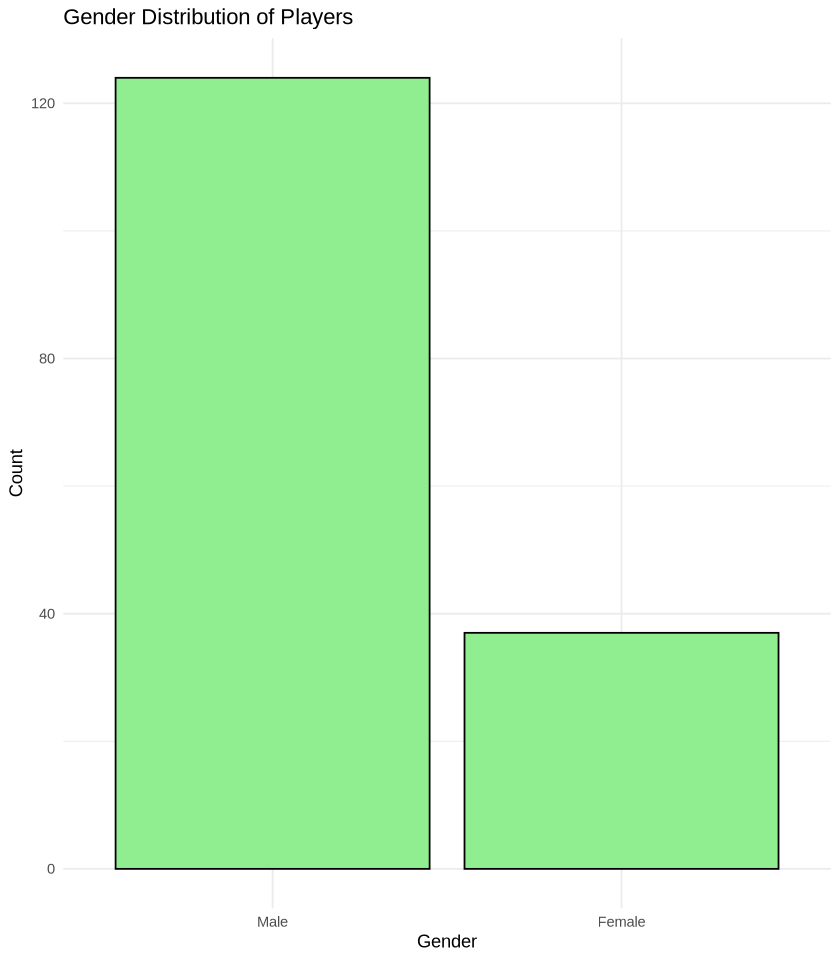

In [37]:
gender_dist <- ggplot(players_filtered, aes(x = gender)) +
  geom_bar(fill = "lightgreen", color = "black") +
  labs(title = "Gender Distribution of Players",
       x = "Gender",
       y = "Count") +
  theme_minimal()
gender_dist

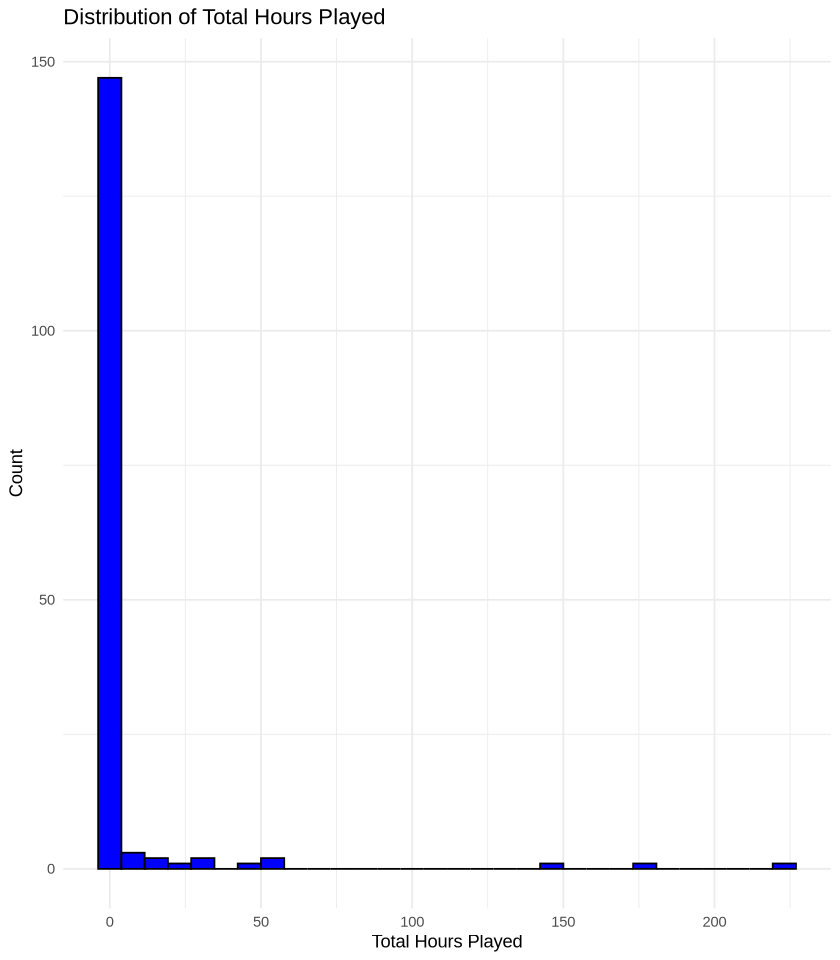

In [38]:
options(repr.plot.height = 8, repr.plot.width = 7)

play_hours <- ggplot(players_filtered, aes(x = played_hours)) +
  geom_histogram(bins = 30, fill = "blue", color = "black") +
  labs(title = "Distribution of Total Hours Played",
       x = "Total Hours Played",
       y = "Count") +
  theme_minimal()
play_hours

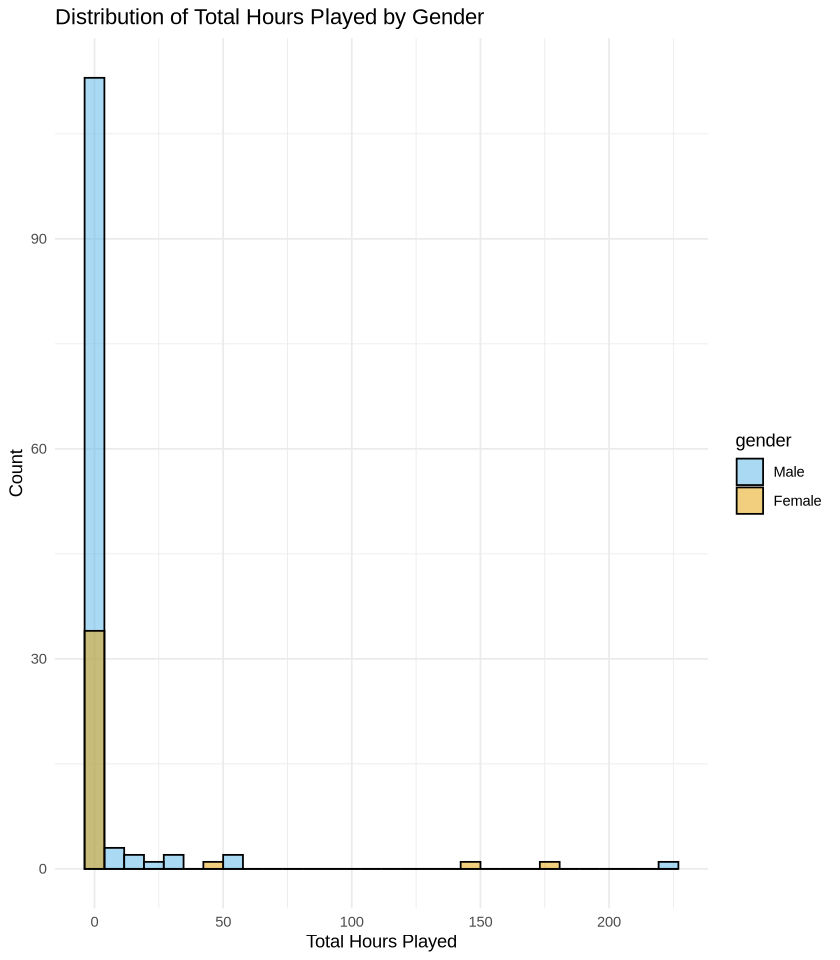

In [39]:
played_hours_hist <- ggplot(players_filtered, aes(x = played_hours, fill = gender)) +
  geom_histogram(position = "identity", alpha = 0.5, bins = 30, color = "black") +
  scale_fill_manual(values = c("Male" = "#56B4E9", "Female" = "#E69F00")) +
  labs(title = "Distribution of Total Hours Played by Gender",
       x = "Total Hours Played",
       y = "Count") +
  theme_minimal()
played_hours_hist